In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.impute import KNNImputer
from itertools import product
from datetime import datetime as dt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
imp = KNNImputer(n_neighbors=7)

# Import Data

In [5]:
c=pd.read_csv('/content/drive/MyDrive/Nykaa Ecommerce Project/Import Files/customer.csv')
p=pd.read_csv('/content/drive/MyDrive/Nykaa Ecommerce Project/Import Files/product.csv')
o=pd.read_csv('/content/drive/MyDrive/Nykaa Ecommerce Project/Import Files/orders.csv')
t=pd.read_csv('/content/drive/MyDrive/Nykaa Ecommerce Project/Import Files/transaction.csv')
r=pd.read_csv('/content/drive/MyDrive/Nykaa Ecommerce Project/Import Files/ratings.csv')
d=pd.read_csv('/content/drive/MyDrive/Nykaa Ecommerce Project/Import Files/delivery.csv')
rr=pd.read_csv('/content/drive/MyDrive/Nykaa Ecommerce Project/Import Files/returns.csv')

# Null Values

In [6]:
# No Null Value

c.isna().sum()
p.isna().sum()
o.isna().sum()
t.isna().sum()
r.isna().sum()
d.isna().sum()
rr.isna().sum()

RT_ID            0
Or_ID            0
Reason           0
Return_Refund    0
Dates            0
dtype: int64

# Duplicate values

In [7]:
# No duplicate

c.duplicated().sum()
p.duplicated().sum()
o.duplicated().sum()
t.duplicated().sum()
r.duplicated().sum()
d.duplicated().sum()
rr.duplicated().sum()

np.int64(0)

# Time Series for Sales

## Data Import

In [20]:
o_f= o[['Order_Date','Or_ID','P_ID','Qty','Discount']]
p_f= p[['P_ID','Price'] ]

In [21]:
order_f= pd.merge(o_f,p_f,on='P_ID',how='left')
order_f.shape

(10000, 6)

## Data Preprocessing

In [22]:
order_f['Sales']=order_f['Price']*order_f['Qty']*(1-order_f['Discount']/100)

In [23]:
order_f['Order_Date']=pd.to_datetime(order_f['Order_Date'])

In [24]:
order_f.sort_values(by='Order_Date',inplace=True)

In [25]:
ord_f=order_f[['Order_Date','Sales']]
ord_f.head(20)

Order_Date      Sales
5437 2023-01-01  4735.2000
5457 2023-01-01  3351.7400
779  2023-01-01   445.8000
7025 2023-01-01  1790.9200
3203 2023-01-01    60.5760
367  2023-01-01   332.3160
4747 2023-01-01  3253.3700
398  2023-01-01  3499.2000
8960 2023-01-01  1392.9900
7788 2023-01-01  1697.8200
9744 2023-01-01   777.1500
7890 2023-01-02  1273.5600
9294 2023-01-02  1629.5000
2698 2023-01-02  2194.6200
1235 2023-01-02  1034.1000
9333 2023-01-02  2473.2928
4510 2023-01-02   653.6600
9903 2023-01-02   106.4250
1967 2023-01-02   261.0720
5237 2023-01-02  3834.0000

In [26]:
ord_fl=ord_f.groupby('Order_Date')['Sales'].mean()

## Check for null and duplicates

In [27]:
ord_fl.isna().sum()

np.int64(0)

In [28]:
ord_fl.duplicated().sum()

np.int64(0)

## Seasonal Decomposition

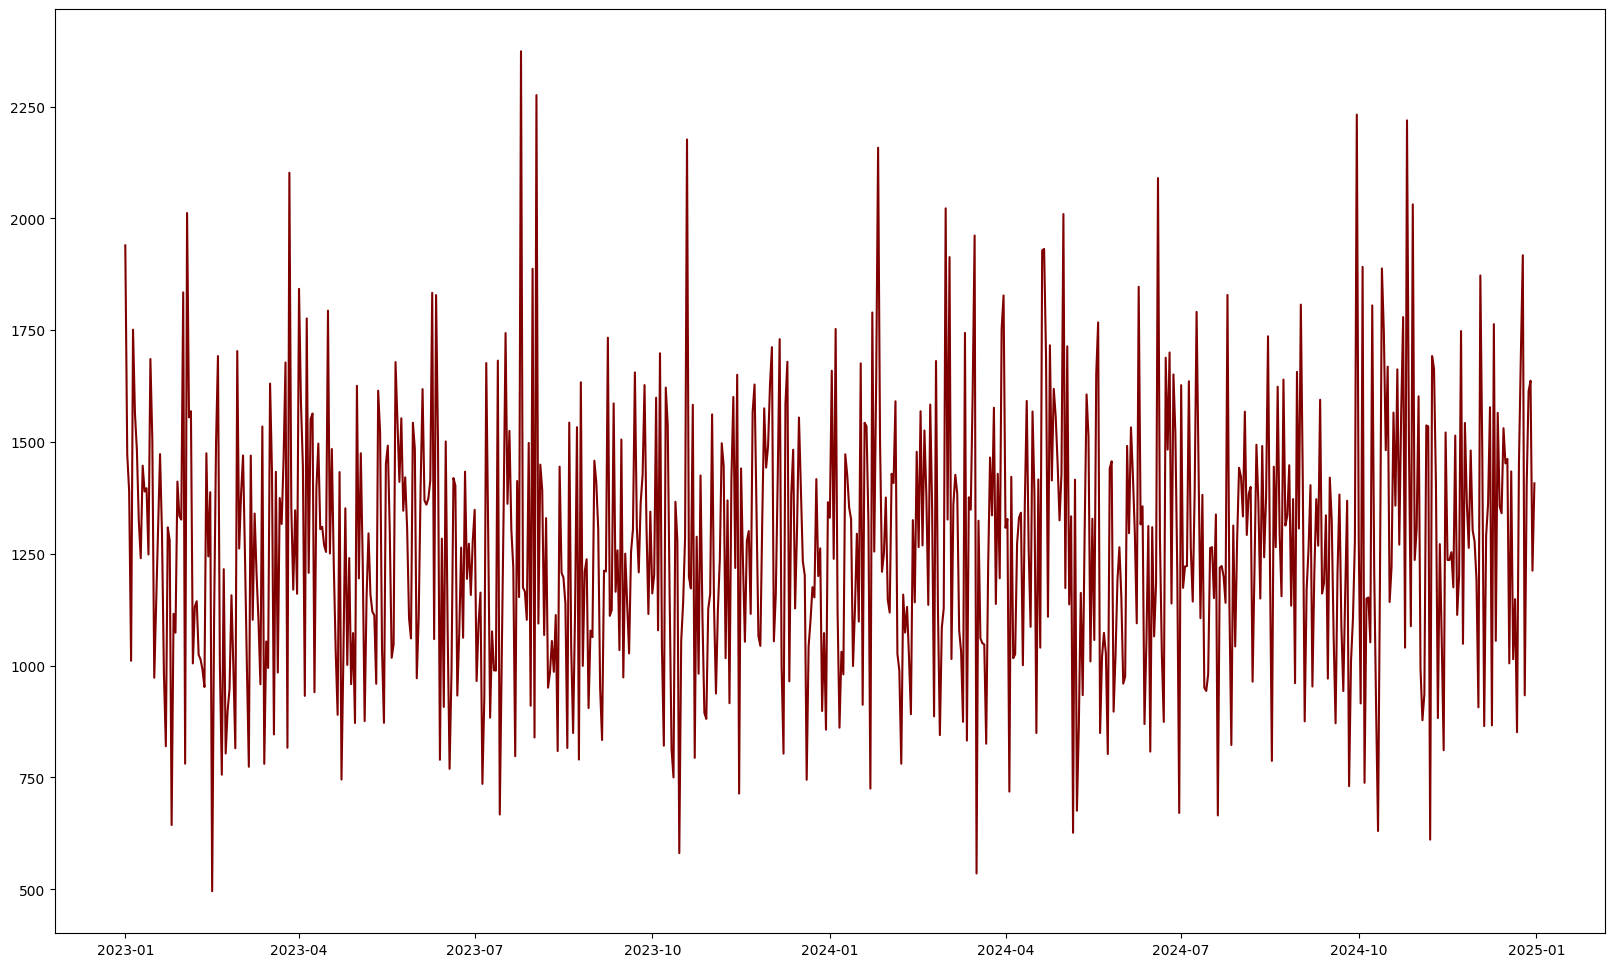

In [29]:
ord_l=ord_fl.reset_index()

plt.figure(figsize=(20,12))
plt.plot(ord_l['Order_Date'],ord_l['Sales'],color='maroon' )
plt.show()

In [30]:
# Additive Seasonal Decomposition

a_ss=seasonal_decompose(ord_fl,model='additive')

original_a=a_ss.observed
trend_a=a_ss.trend
seasonal_a=a_ss.seasonal
irrg_a=a_ss.resid

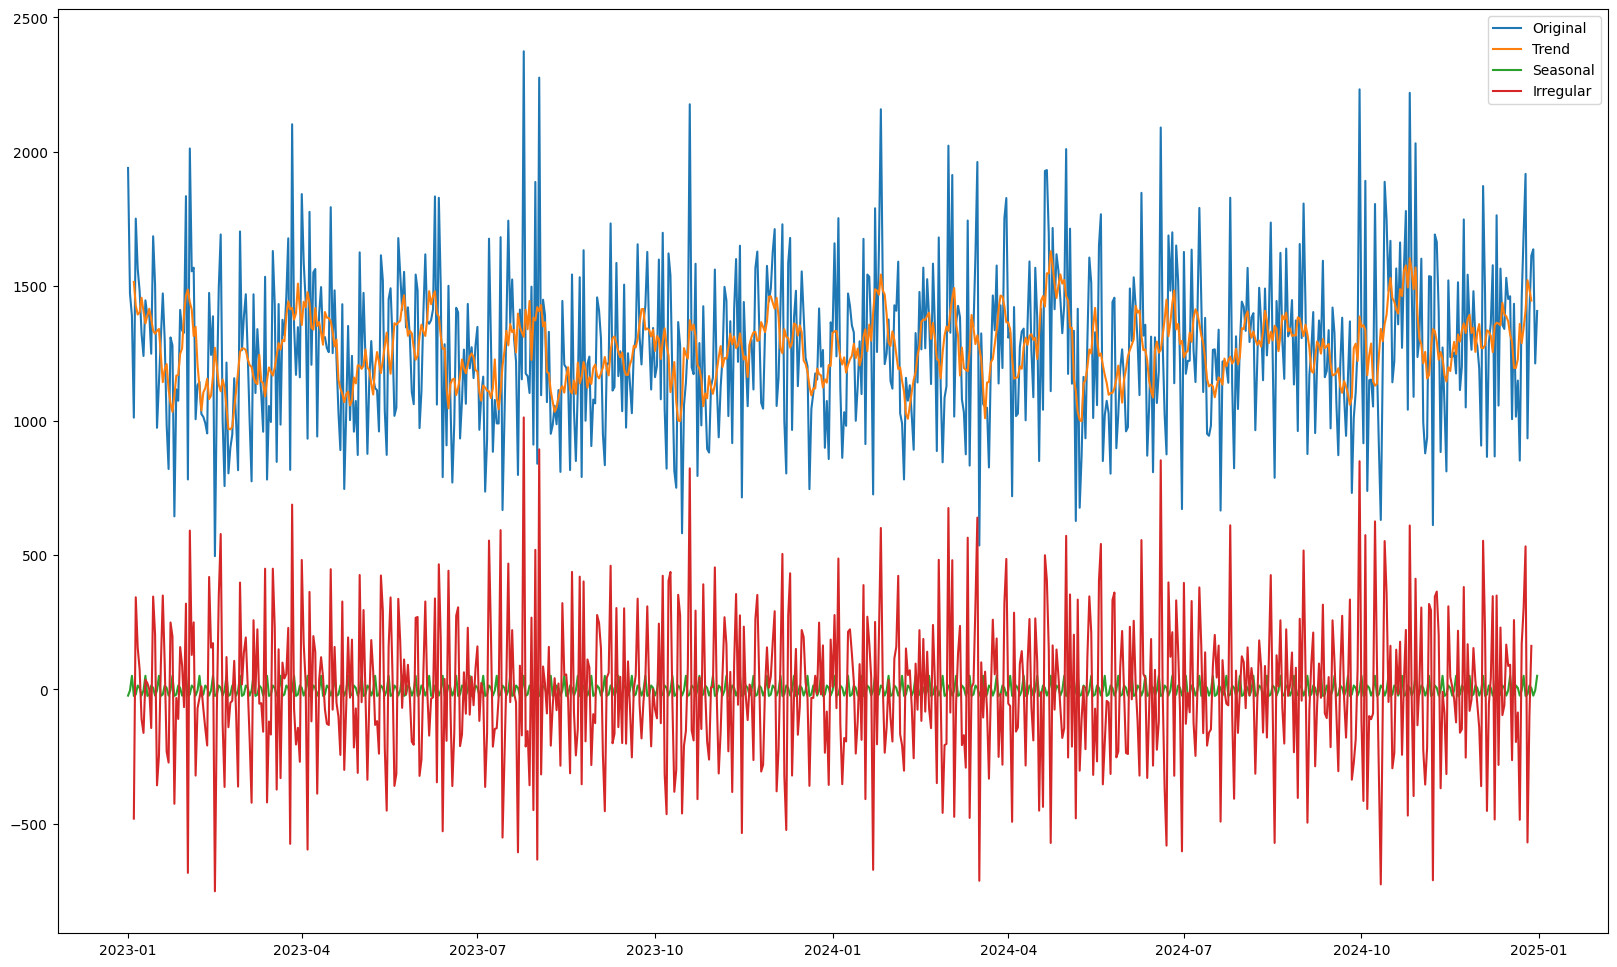

In [31]:
plt.figure(figsize=(20,12))

plt.plot(original_a,label='Original')
plt.plot(trend_a,label='Trend')
plt.plot(seasonal_a,label='Seasonal')
plt.plot(irrg_a,label='Irregular')

plt.legend()
plt.show()


In [32]:
# Multiplicative seasonal decomposition

m_ss=seasonal_decompose(ord_fl,model='multiplicative' )

original_m=m_ss.observed
trend_m=m_ss.trend
seasonal_m=m_ss.seasonal
irrg_m=m_ss.resid

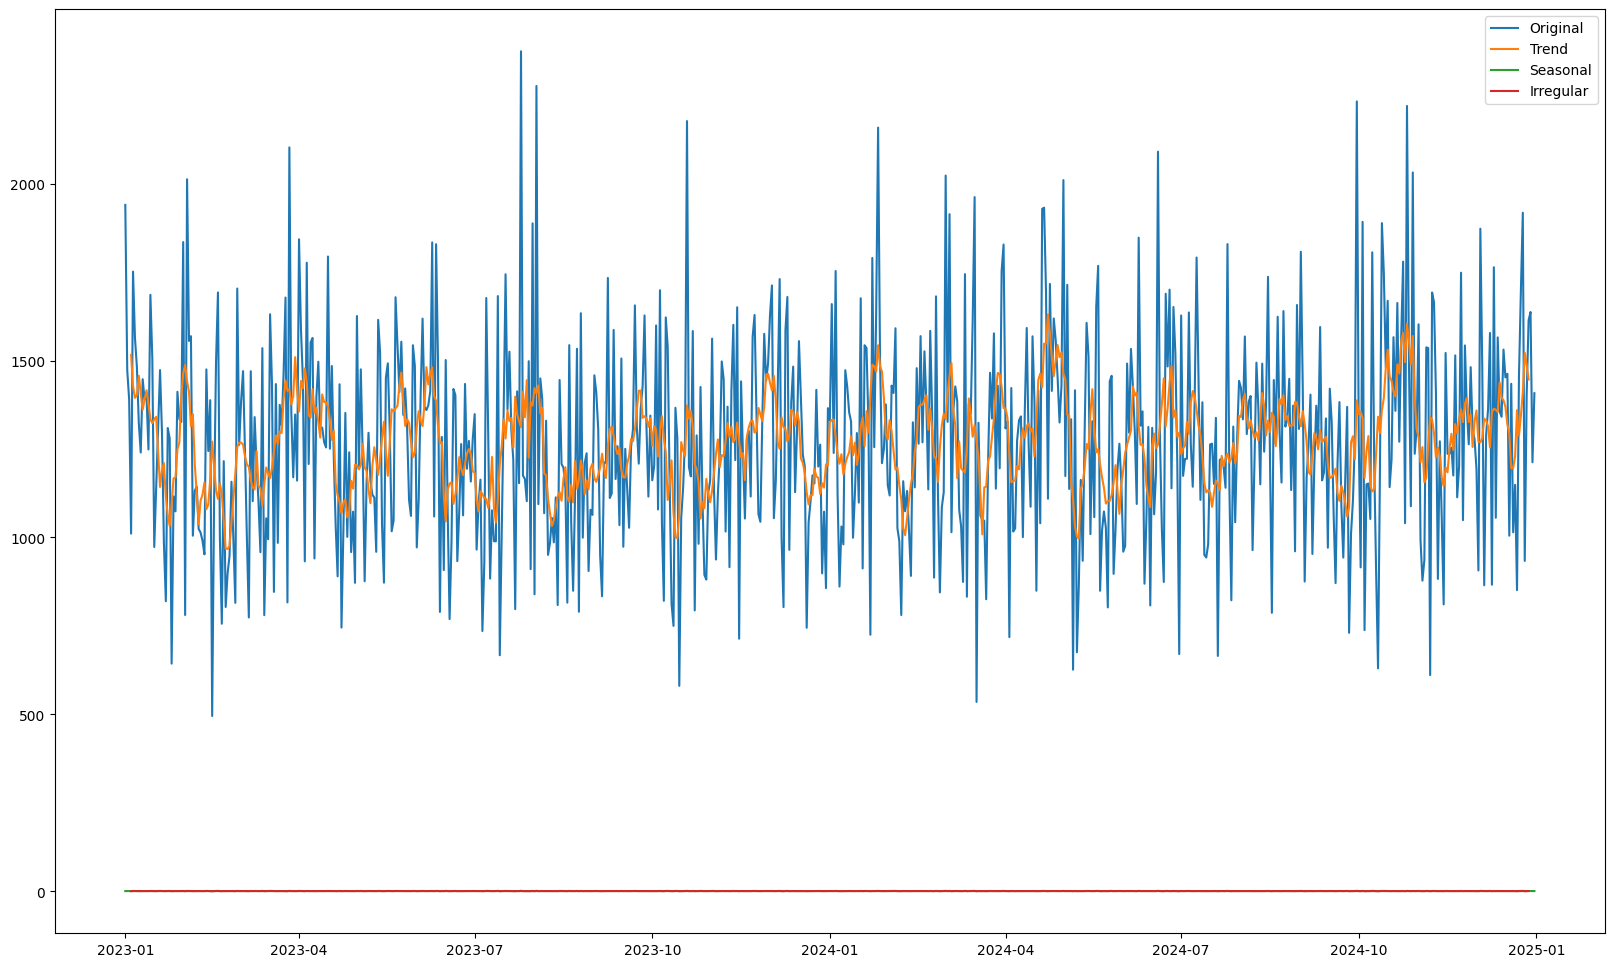

In [33]:
plt.figure(figsize=(20,12))

plt.plot(original_m,label='Original')
plt.plot(trend_m,label='Trend')
plt.plot(seasonal_m,label='Seasonal')
plt.plot(irrg_m,label='Irregular')

plt.legend()
plt.show()


## Check for stationarity

In [114]:
def adf_test(dt):
  adf_t=adfuller(dt)
  test_stat=adf_t[0]
  prob=adf_t[1]
  print('Test Stats: ',test_stat)
  print('P_Val: ',prob )
  alpha=0.05
  if prob>alpha:
    print('Data is not stationary')
  else:
    print('Data is stationary')

In [35]:
adf_test(ord_fl)

Test Stats:  -27.3528493813759
P_Val:  0.0
Data is stationary


## Train and Test Divide

In [36]:
train=ord_fl[0:631]
test=ord_fl[631:]

## Hyperparametric tuning

In [37]:
P=list(range(0,20))
D=list(range(0,2))
Q=list(range(0,18))

In [38]:
arima=list(product(P,D,Q))
arima[:10]

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 9)]

In [ ]:
p_ar=[]
d_ar=[]
q_ar=[]
rmse_ar=[]

for i,j,k in arima:
  model=ARIMA(np.log(train),order=(i,j,k))
  model_t=model.fit()
  pred=np.exp(model_t.forecast(len(test)))
  rmse=root_mean_squared_error(test,pred)
  p_ar.append(i)
  d_ar.append(j)
  q_ar.append(k)
  rmse_ar.append(rmse)
  print('P:',i,' D:',j,' Q:',k,' RMSE:',rmse)

In [ ]:
res=pd.DataFrame({'P':p_ar,'D':d_ar,'Q':q_ar,'RMSE':rmse_ar})
res.sort_values(by='RMSE',ascending=True,inplace=True)
res.head()

P  D  Q        RMSE
703  19  1  1  342.511529
667  18  1  1  342.587681
348   9  1  6  342.786425
416  11  1  2  342.787303
240   6  1  6  343.050650

In [40]:
p_b_d= 19
d_b_d=1
q_b_d=1

In [ ]:
p_b= int(res['P'].iloc[0])
d_b=int(res['D'].iloc[0])
q_b=int(res['Q'].iloc[0])

## Prediction using Best Parameter

#### Here prediction of Sales done for whole year of 2025

In [41]:
date_r=pd.date_range(start='2025-1-1',end='2025-12-31')
len(date_r)

365

In [42]:
pred_2025=pd.DataFrame(index=date_r)

In [43]:
model=ARIMA(np.log(ord_fl),order=(p_b_d,d_b_d,q_b_d))
model_f=model.fit()

pred_25=np.exp(model_f.forecast(len(pred_2025)))
pred_2025['Sales']=pred_25

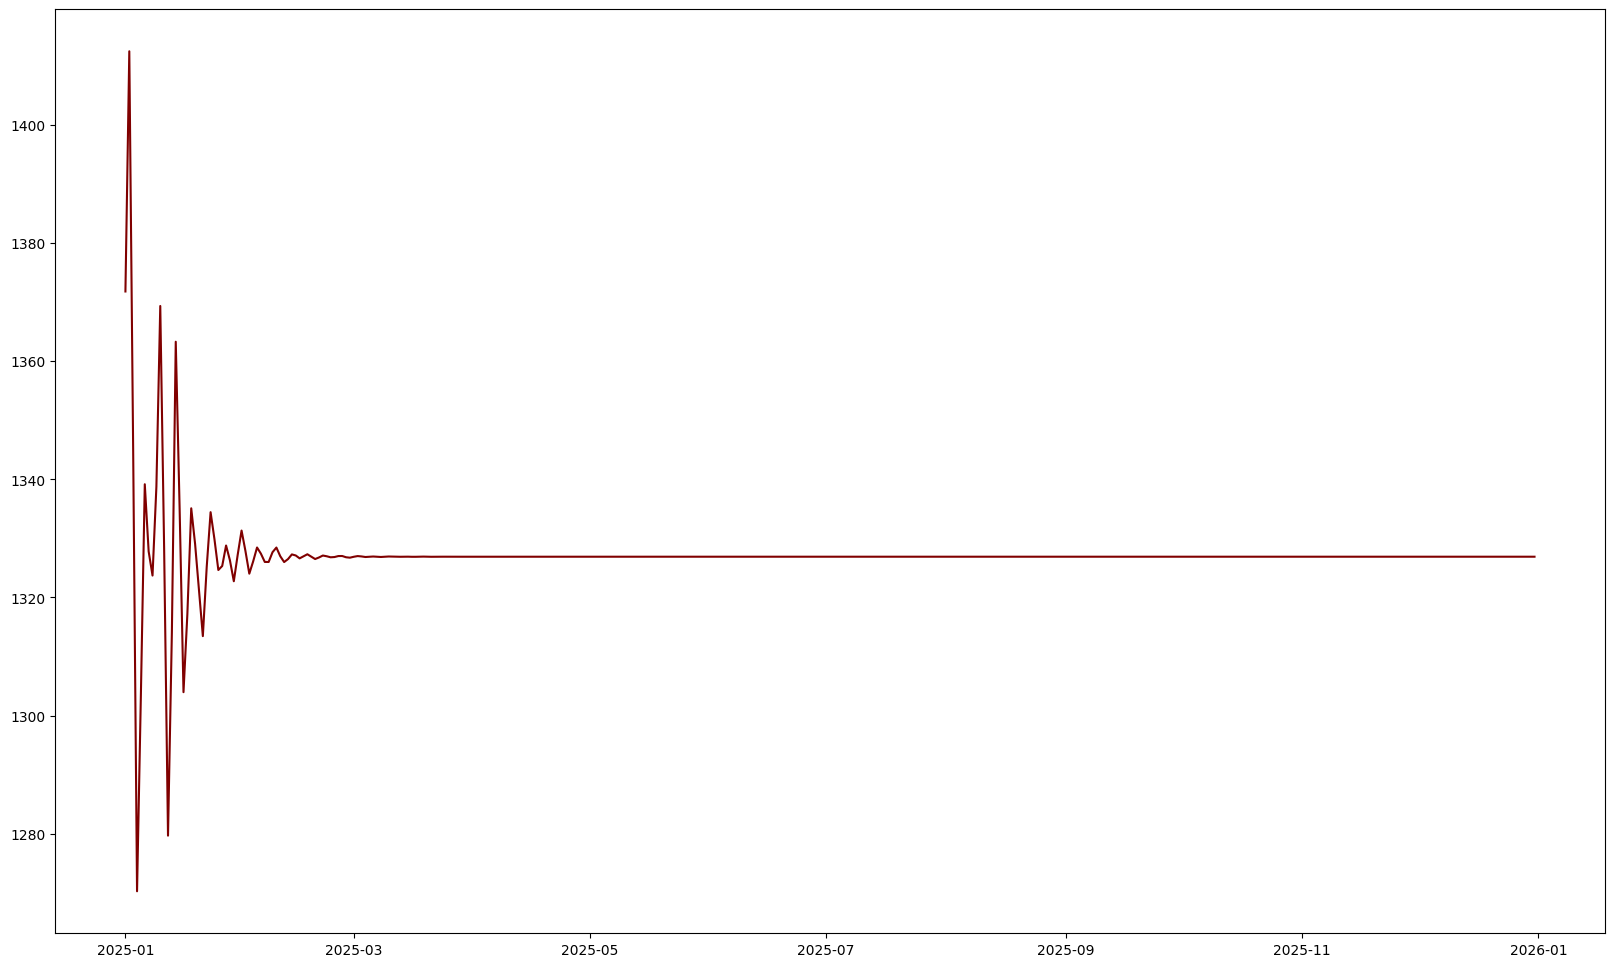

In [50]:
pred_2025_l=pred_2025.reset_index()

plt.figure(figsize=(20,12))
plt.plot(pred_2025_l['index'],pred_2025_l['Sales'],color='maroon' )
plt.show()

In [ ]:
pred_2025.to_csv('Sales_2025.csv')

# Time Series for Delivery Partner

## Data Import

In [31]:
o_d= o[['Order_Date','Or_ID','P_ID','Qty','Discount','DP_ID']]
p_d= p[['P_ID','Price'] ]
d_d=d[['DP_ID','Percent_Cut']]

In [32]:
dev= pd.merge(o_d,p_d,on='P_ID',how='left')
dev_d= pd.merge(dev,d_d,on='DP_ID',how='left')
dev_d.sort_values(by='Order_Date',inplace=True)

## Data Preprocessing

In [33]:
dev_d['Revenue']=dev_d['Price']*dev_d['Qty']*(1-dev_d['Discount']/100)*(dev_d['Percent_Cut']/100)

In [34]:
del_f=dev_d[['Order_Date','Revenue']]
del_f['Order_Date']=pd.to_datetime(del_f['Order_Date'])

In [60]:
del_fl=del_f.groupby('Order_Date')['Revenue'].mean()

## Check for Null and Duplicate

In [61]:
del_fl.isna().sum()

np.int64(0)

In [62]:
del_fl.duplicated().sum()

np.int64(0)

## Seasonal Decomposition

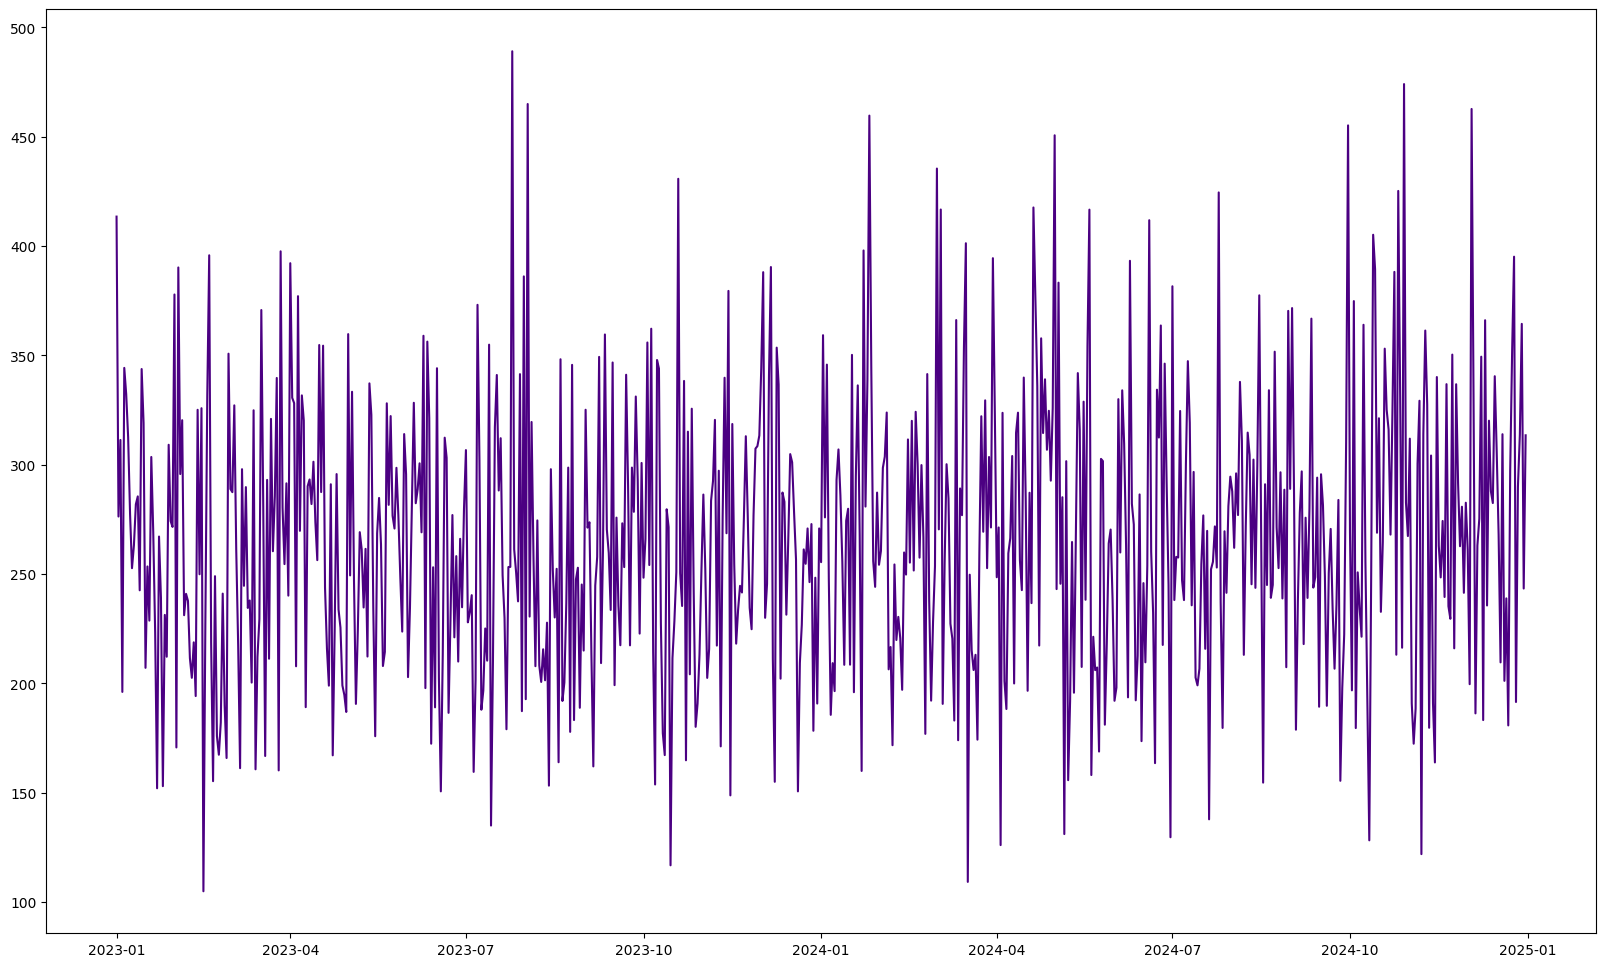

In [63]:
del_l=del_fl.reset_index()

plt.figure(figsize=(20,12))
plt.plot(del_l['Order_Date'],del_l['Revenue'],color='Indigo' )
plt.show()

In [64]:
# Additive Decompotition

a_ss_f=seasonal_decompose(del_fl,model='additive')

original_a_f=a_ss_f.observed.reset_index()
trend_a_f=a_ss_f.trend.reset_index()
seasonal_a_f=a_ss_f.seasonal.reset_index()
irrg_a_f=a_ss_f.resid.reset_index()

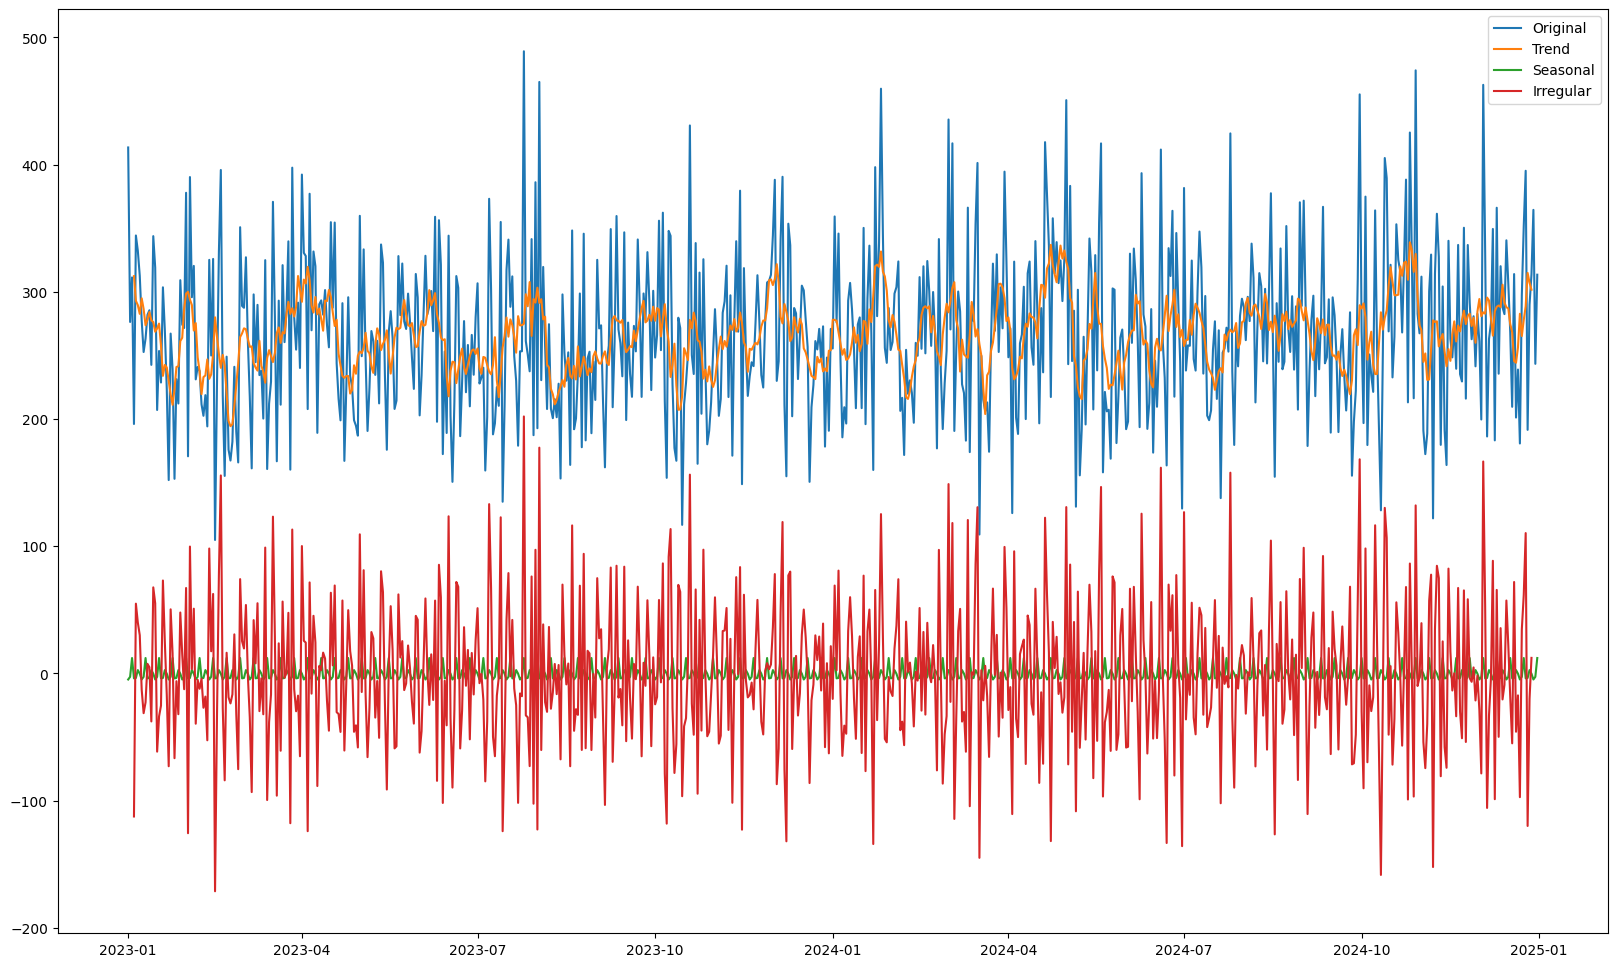

In [65]:
plt.figure(figsize=(20,12))
plt.plot(original_a_f['Order_Date'],original_a_f['Revenue'],label='Original')
plt.plot(trend_a_f['Order_Date'],trend_a_f['trend'],label='Trend')
plt.plot(seasonal_a_f['Order_Date'],seasonal_a_f['seasonal'],label='Seasonal')
plt.plot(irrg_a_f['Order_Date'],irrg_a_f['resid'],label='Irregular')

plt.legend()
plt.show()

In [66]:
# Multiplicative Decomposition

m_ss_f=seasonal_decompose(del_fl,model='multiplicative')

original_m_f=m_ss_f.observed.reset_index()
trend_m_f=m_ss_f.trend.reset_index()
seasonal_m_f=m_ss_f.seasonal.reset_index()
irrg_m_f=m_ss_f.resid.reset_index()

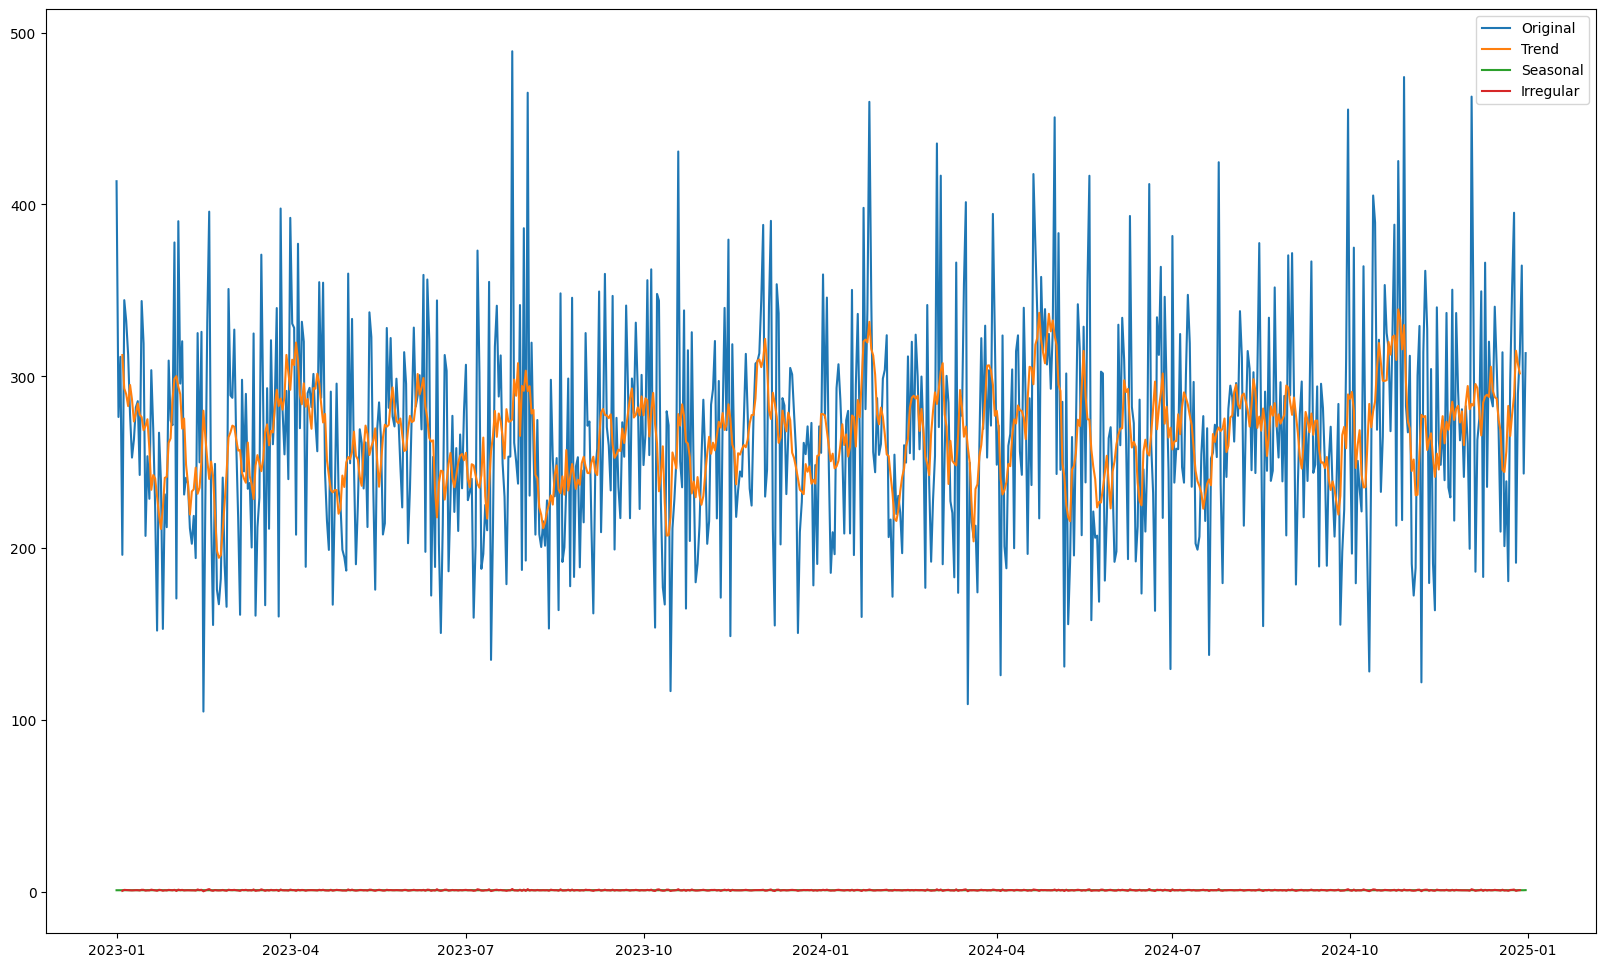

In [67]:
plt.figure(figsize=(20,12))
plt.plot(original_m_f['Order_Date'],original_m_f['Revenue'],label='Original')
plt.plot(trend_m_f['Order_Date'],trend_m_f['trend'],label='Trend')
plt.plot(seasonal_m_f['Order_Date'],seasonal_m_f['seasonal'],label='Seasonal')
plt.plot(irrg_m_f['Order_Date'],irrg_m_f['resid'],label='Irregular')

plt.legend()
plt.show()

## Check for Stationarity

In [68]:
adf_test(del_fl)

Test Stats:  -27.480472047866467
P_Val:  0.0
Data is stationary


## Train Test Divide

In [69]:
train_d=del_fl[0:631]
test_d=del_fl[631:]

## Hyperparameter Tuning

In [70]:
P=list(range(0,20))
D=list(range(0,2))
Q=list(range(0,18))

In [71]:
arima_d=list(product(P,D,Q))
arima_d[:10]

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 9)]

In [ ]:
p_dv=[]
d_dv=[]
q_dv=[]
rmse_dv=[]

for i,j,k in arima_d:
  model_dv=ARIMA(np.log(train_d),order=(i,j,k))
  model_t_dv=model_dv.fit()
  pred_d=np.exp(model_t_dv.forecast(len(test_d)))
  rmse_d=root_mean_squared_error(test_d,pred_d)
  p_dv.append(i)
  d_dv.append(j)
  q_dv.append(k)
  rmse_dv.append(rmse_d)

In [ ]:
res_dv=pd.DataFrame({'P':p_dv,'D':d_dv,'Q':q_dv,'RMSE':rmse_dv})
res_dv.sort_values(by='RMSE',ascending=True,inplace=True)
res_dv.head()

P  D   Q       RMSE
599  16  1   5  74.539404
677  18  1  11  74.589011
390  10  1  12  74.671117
631  17  1   1  74.695157
636  17  1   6  74.758758

In [75]:
p_b_dv= 16
d_b_dv=1
q_b_dv=5

In [ ]:
p_b_dl= int(res_dv['P'].iloc[0])
d_b_dl=int(res_dv['D'].iloc[0])
q_b_dl=int(res_dv['Q'].iloc[0])

## Prediction using Best Parameter

####  Here prediction of Revenue done for whole year of 2025

In [72]:
date_r=pd.date_range(start='2025-1-1',end='2025-12-31')
len(date_r)

365

In [73]:
pred_dv_2025=pd.DataFrame(index=date_r)

In [76]:
model_dv_f=ARIMA( np.log(del_fl),order=(p_b_dv,d_b_dv,q_b_dv)  )
model_f_dv_f=model_dv_f.fit()

pred_f_dv= np.exp(model_f_dv_f.forecast(len(pred_dv_2025)))
pred_dv_2025['Revenue']=pred_f_dv

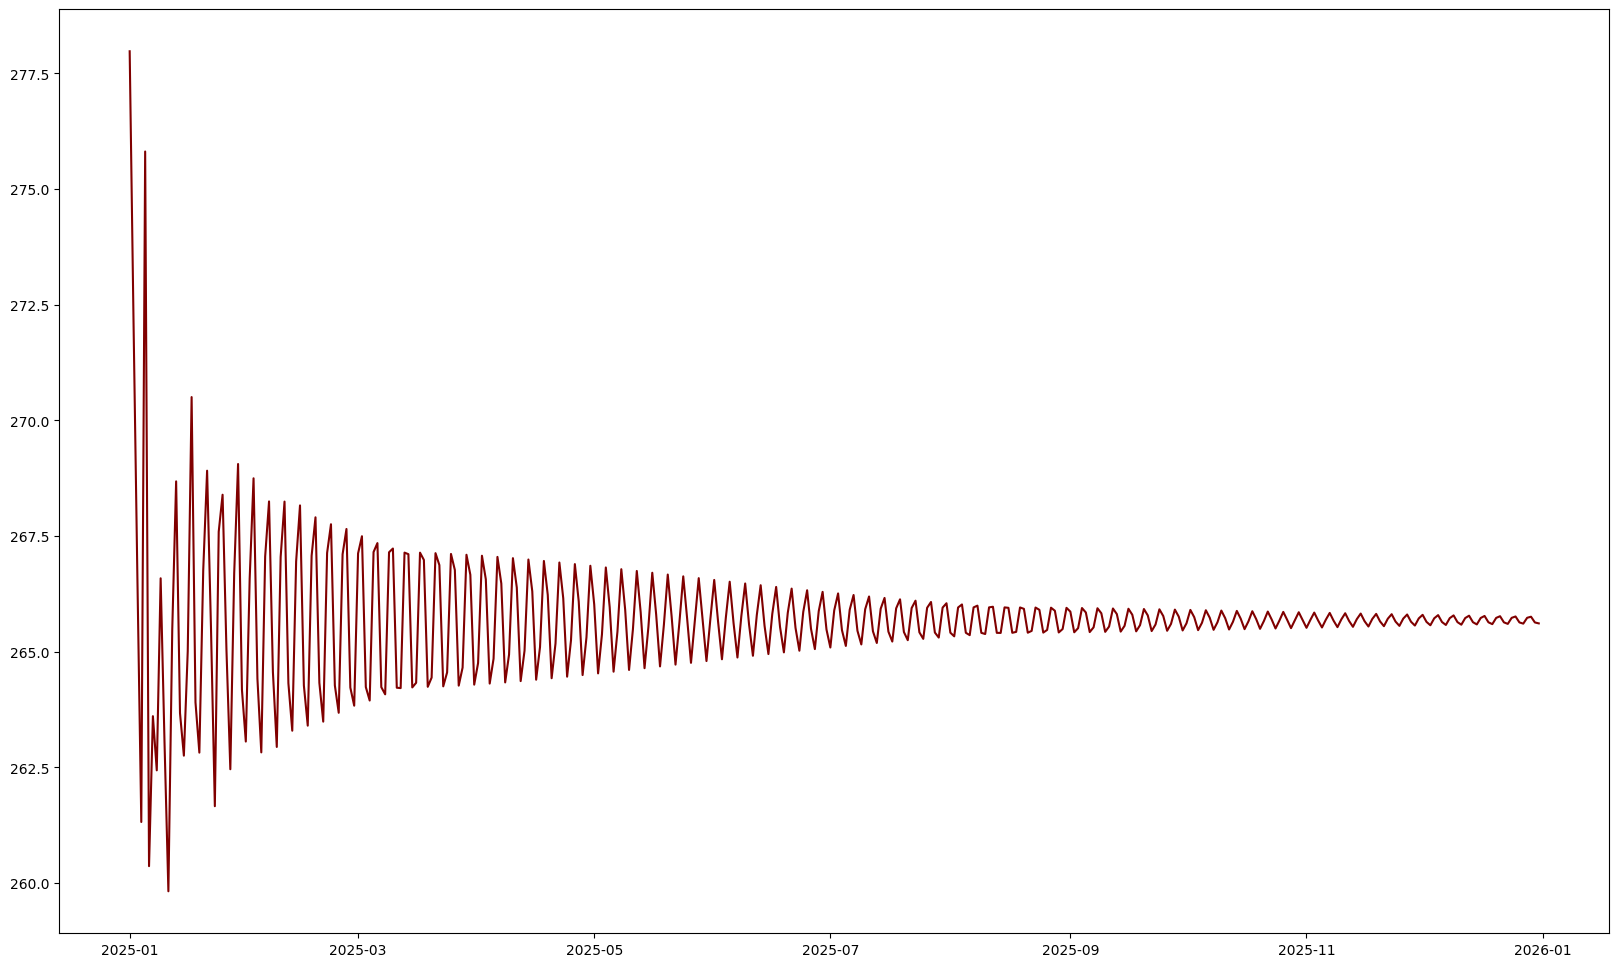

In [78]:
pred_dv_2025_l=pred_dv_2025.reset_index()

plt.figure(figsize=(20,12))
plt.plot(pred_dv_2025_l['index'],pred_dv_2025_l['Revenue'],color='maroon' )
plt.show()

In [ ]:
pred_dv_2025.to_csv('Revenue_Delivery_Partner_2025.csv')

# Time Series for Return Loss

## Data Import

In [51]:
rr_rl=rr[['RT_ID','Or_ID','Dates']]
o_rl=o[['Or_ID','P_ID','Qty','Discount']]
p_rl=p[['P_ID','Price']]

In [52]:
ret_rl=pd.merge(rr_rl,o_rl,on='Or_ID',how='left')
ret_rl_f=pd.merge(ret_rl,p_rl,on='P_ID',how='left')

ret_rl_f['Loss']=ret_rl_f['Price']*ret_rl_f['Qty']*(1-ret_rl_f['Discount']/100)

In [53]:
ret_rl_f.sort_values(by='Dates',inplace=True)

## Data Preprocessing

In [92]:
ret_rl_f['Dates']=pd.to_datetime(ret_rl_f['Dates'])

In [98]:
ret_rl_fl=ret_rl_f.groupby('Dates')['Loss'].mean()

In [99]:
d_range=pd.date_range(start= ret_rl_f['Dates'].min(),end=ret_rl_f['Dates'].max())
ret_rl_fl=ret_rl_fl.reindex(d_range)

In [100]:
ret_rl_fl.isna().sum()

np.int64(45)

In [101]:
ret_rl_fl=ret_rl_fl.ffill()

## Seasonal Decomposition

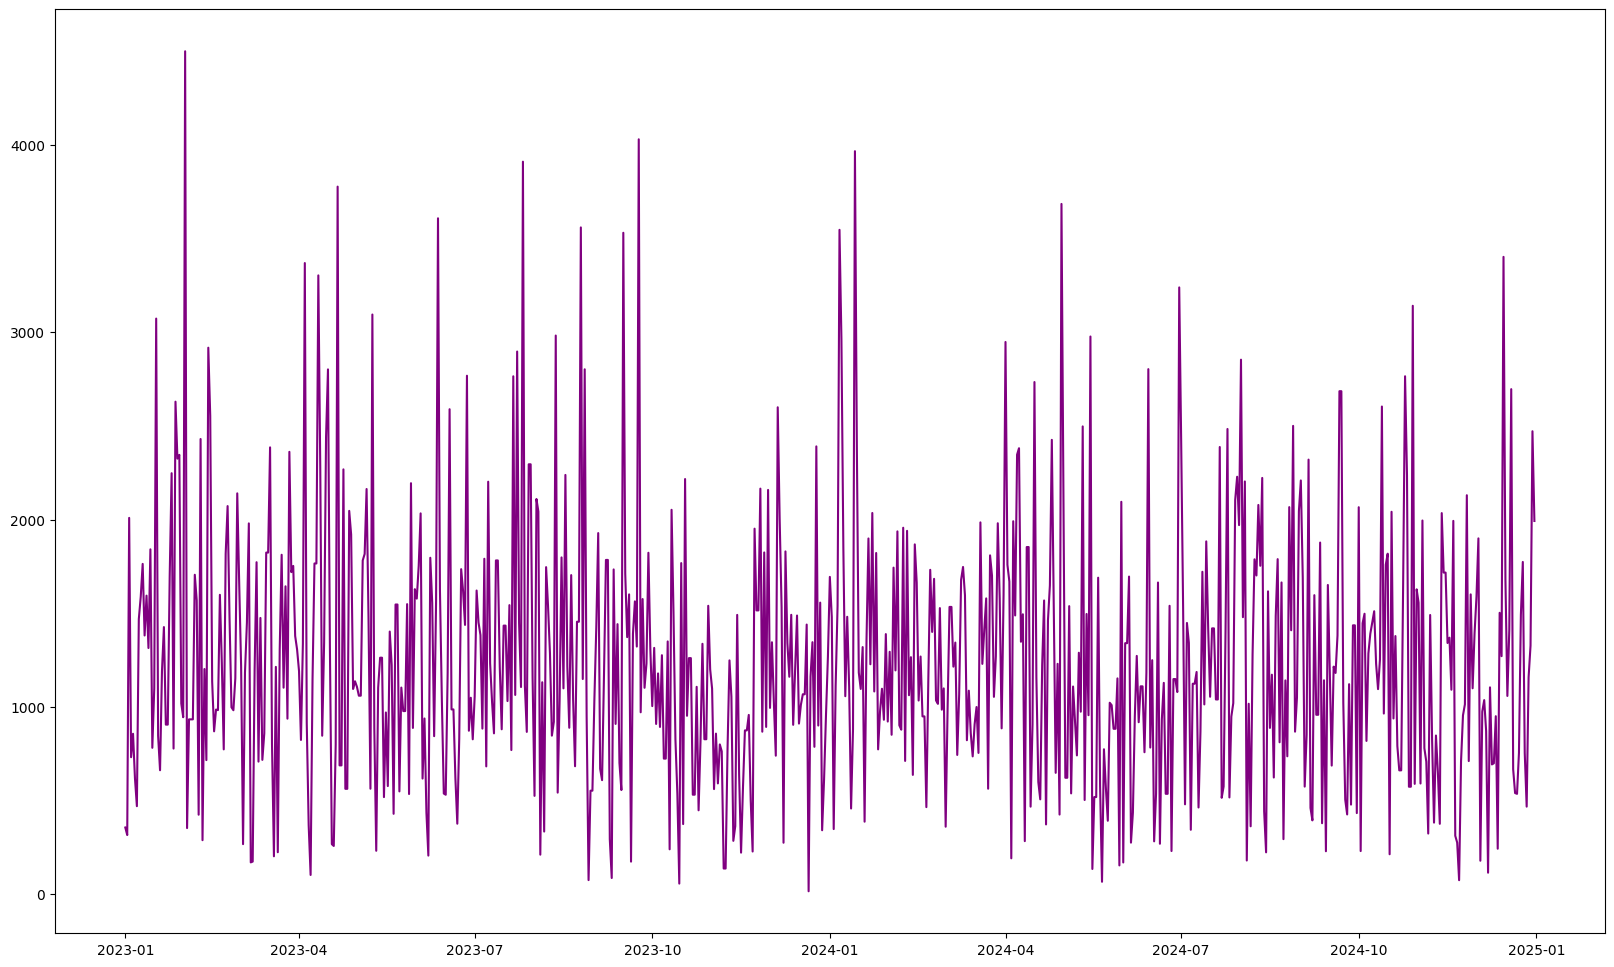

In [104]:
ret_rl_fl_p=ret_rl_fl.reset_index()

plt.figure(figsize=(20,12))
plt.plot(ret_rl_fl_p['index'],ret_rl_fl_p['Loss'],color='purple' )
plt.show()

In [105]:
# Additive decomposition

a_ss_rl=seasonal_decompose(ret_rl_fl,model='additive')

original_a_rl=a_ss_rl.observed.reset_index()
trend_a_rl=a_ss_rl.trend.reset_index()
seasonal_a_rl=a_ss_rl.seasonal.reset_index()
irrg_a_rl=a_ss_rl.resid.reset_index()

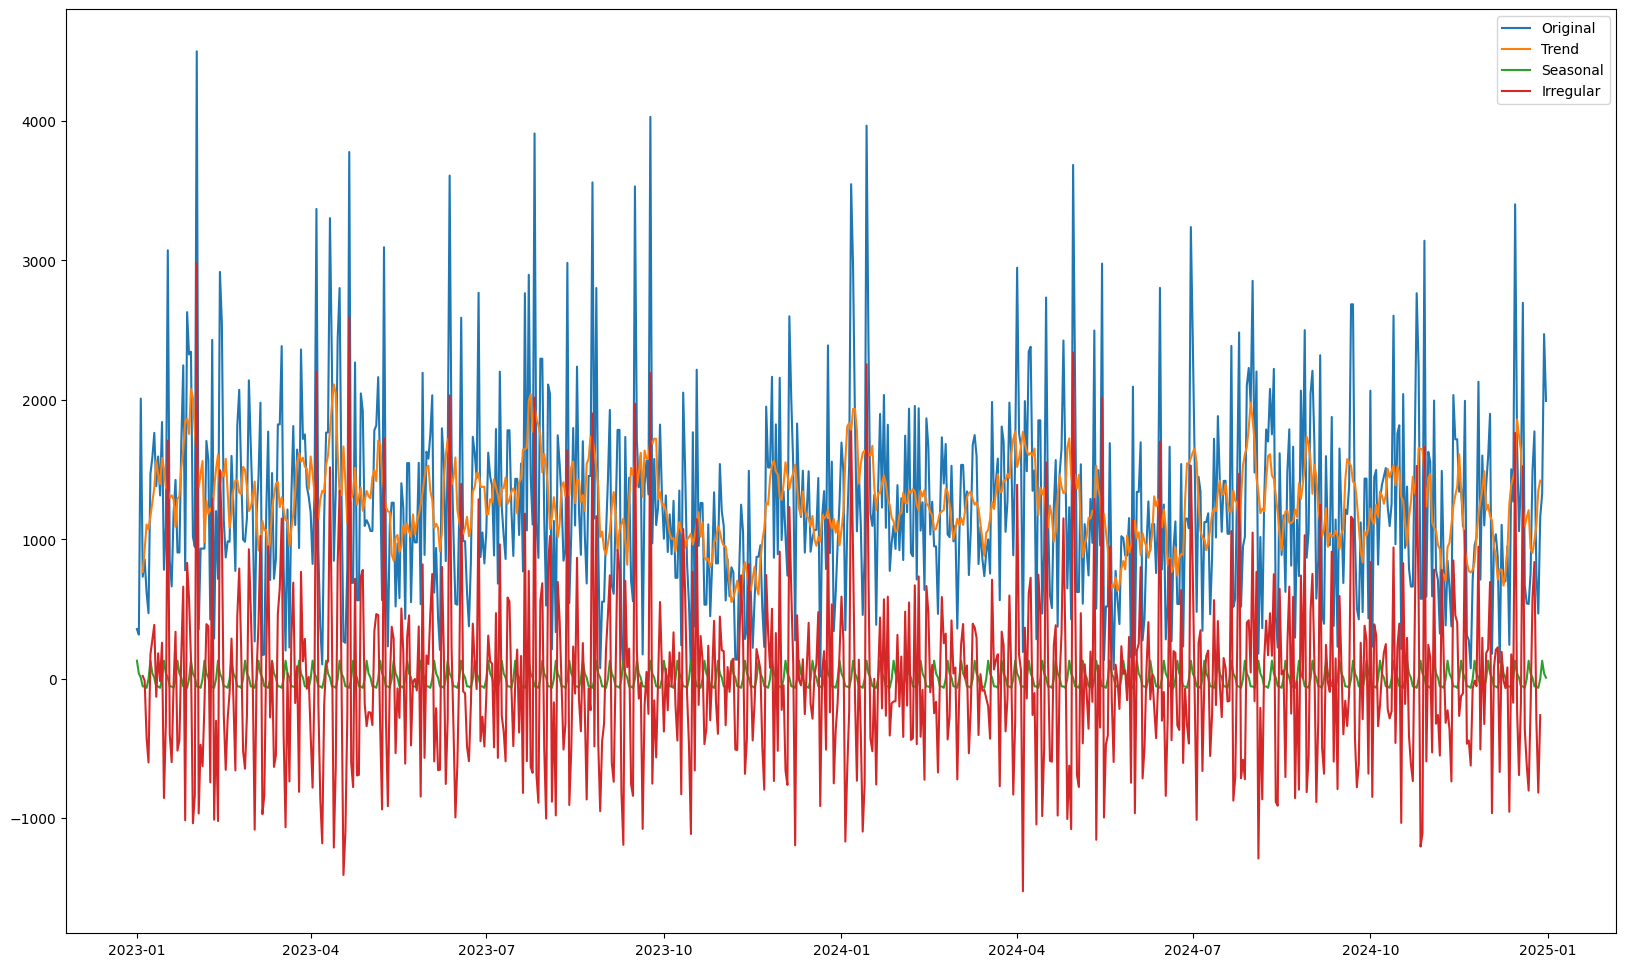

In [110]:
plt.figure(figsize=(20,12))
plt.plot(original_a_rl['index'],original_a_rl['Loss'],label='Original')
plt.plot(trend_a_rl['index'],trend_a_rl['trend'],label='Trend')
plt.plot(seasonal_a_rl['index'],seasonal_a_rl['seasonal'],label='Seasonal')
plt.plot(irrg_a_rl['index'],irrg_a_rl['resid'],label='Irregular')

plt.legend()
plt.show()

In [111]:
# Multiplicative decomposition

m_ss_rl=seasonal_decompose(ret_rl_fl,model='multiplicative')

original_m_rl=m_ss_rl.observed.reset_index()
trend_m_rl=m_ss_rl.trend.reset_index()
seasonal_m_rl=m_ss_rl.seasonal.reset_index()
irrg_m_rl=m_ss_rl.resid.reset_index()

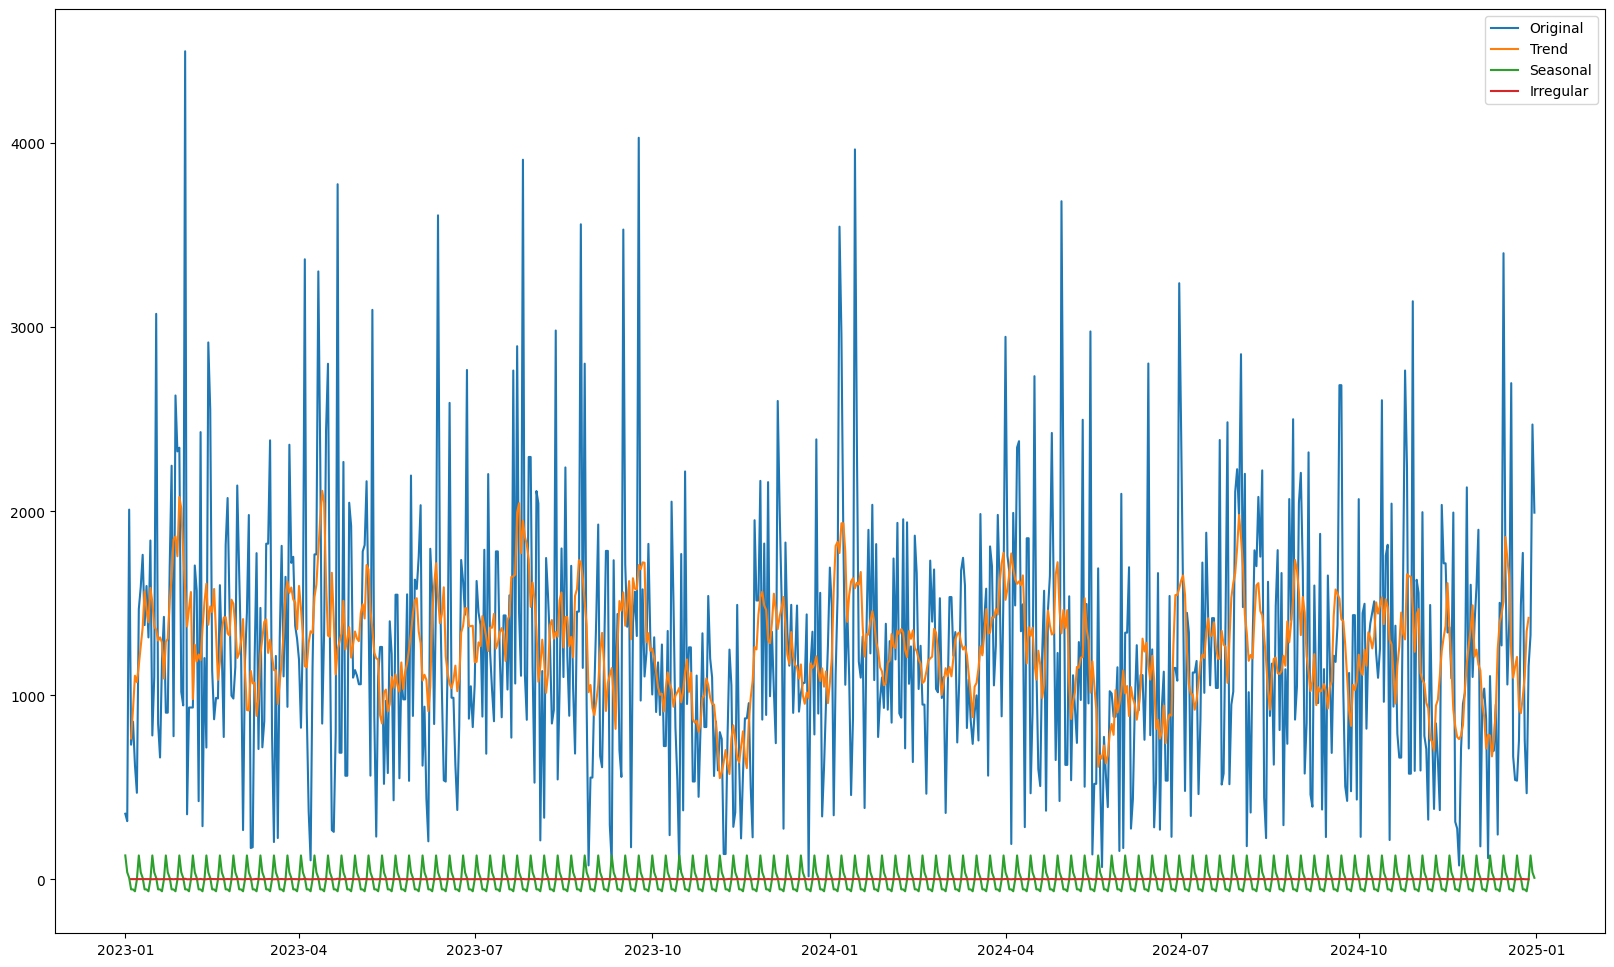

In [112]:
plt.figure(figsize=(20,12))
plt.plot(original_m_rl['index'],original_m_rl['Loss'],label='Original')
plt.plot(trend_m_rl['index'],trend_m_rl['trend'],label='Trend')
plt.plot(seasonal_a_rl['index'],seasonal_a_rl['seasonal'],label='Seasonal')
plt.plot(irrg_m_rl['index'],irrg_m_rl['resid'],label='Irregular')

plt.legend()
plt.show()

## Check for Stationarity

In [115]:
adf_test(ret_rl_fl)

Test Stats:  -25.73362339490095
P_Val:  0.0
Data is stationary


## Train Test Divide

In [120]:
train_rt=ret_rl_fl[0:631]
test_rt=ret_rl_fl[631:]

## Hyperparameter Tuning

In [118]:
P=list(range(0,20))
D=list(range(0,2))
Q=list(range(0,18))

In [119]:
arima_rt=list(product(P,D,Q))
arima_rt[:10]

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 9)]

In [ ]:
p_rt=[]
d_rt=[]
q_rt=[]
rmse_rt=[]

for i,j,k in arima_rt:
  model_rt=ARIMA(np.log(train_rl),order=(i,j,k))
  model_t_rt=model_rt.fit()
  pred_rt=np.exp(model_t_rt.forecast(len(test_rt)))
  rmse_d=root_mean_squared_error(test_rt,pred_rt)
  p_rt.append(i)
  d_rt.append(j)
  q_rt.append(k)
  rmse_rt.append(rmse_d)


In [124]:
res_rt=pd.DataFrame({'P':p_rt,'D':d_rt,'Q':q_rt,'RMSE':rmse_rt})
res_rt.sort_values(by='RMSE',ascending=True,inplace=True)
res_rt.head()

P  D  Q        RMSE
630  17  1  0  669.111766
702  19  1  0  671.280190
666  18  1  0  671.376519
558  15  1  0  671.980801
594  16  1  0  672.015939

In [125]:
p_b_rt= 17
d_b_rt=1
q_b_rt=0

In [126]:
p_f_rt= int(res_rt['P'].iloc[0])
d_f_rt=int(res_rt['D'].iloc[0])
q_f_rt=int(res_rt['Q'].iloc[0])

## Prediction using Best Parameter


####  Here prediction of Revenue Loss done for whole year of 2025

In [127]:
date_rl=pd.date_range(start='2025-1-1',end='2025-12-31')
len(date_rl)

365

In [128]:
pred_rt_2025=pd.DataFrame(index=date_rl)

In [130]:
model_rt_f=ARIMA( np.log(ret_rl_fl),order=(p_b_rt,d_b_rt,q_b_rt)  )
model_f_rt_f=model_rt_f.fit()

pred_f_rt= np.exp(model_f_rt_f.forecast(len(pred_rt_2025)))
pred_rt_2025['Revenue']=pred_f_rt

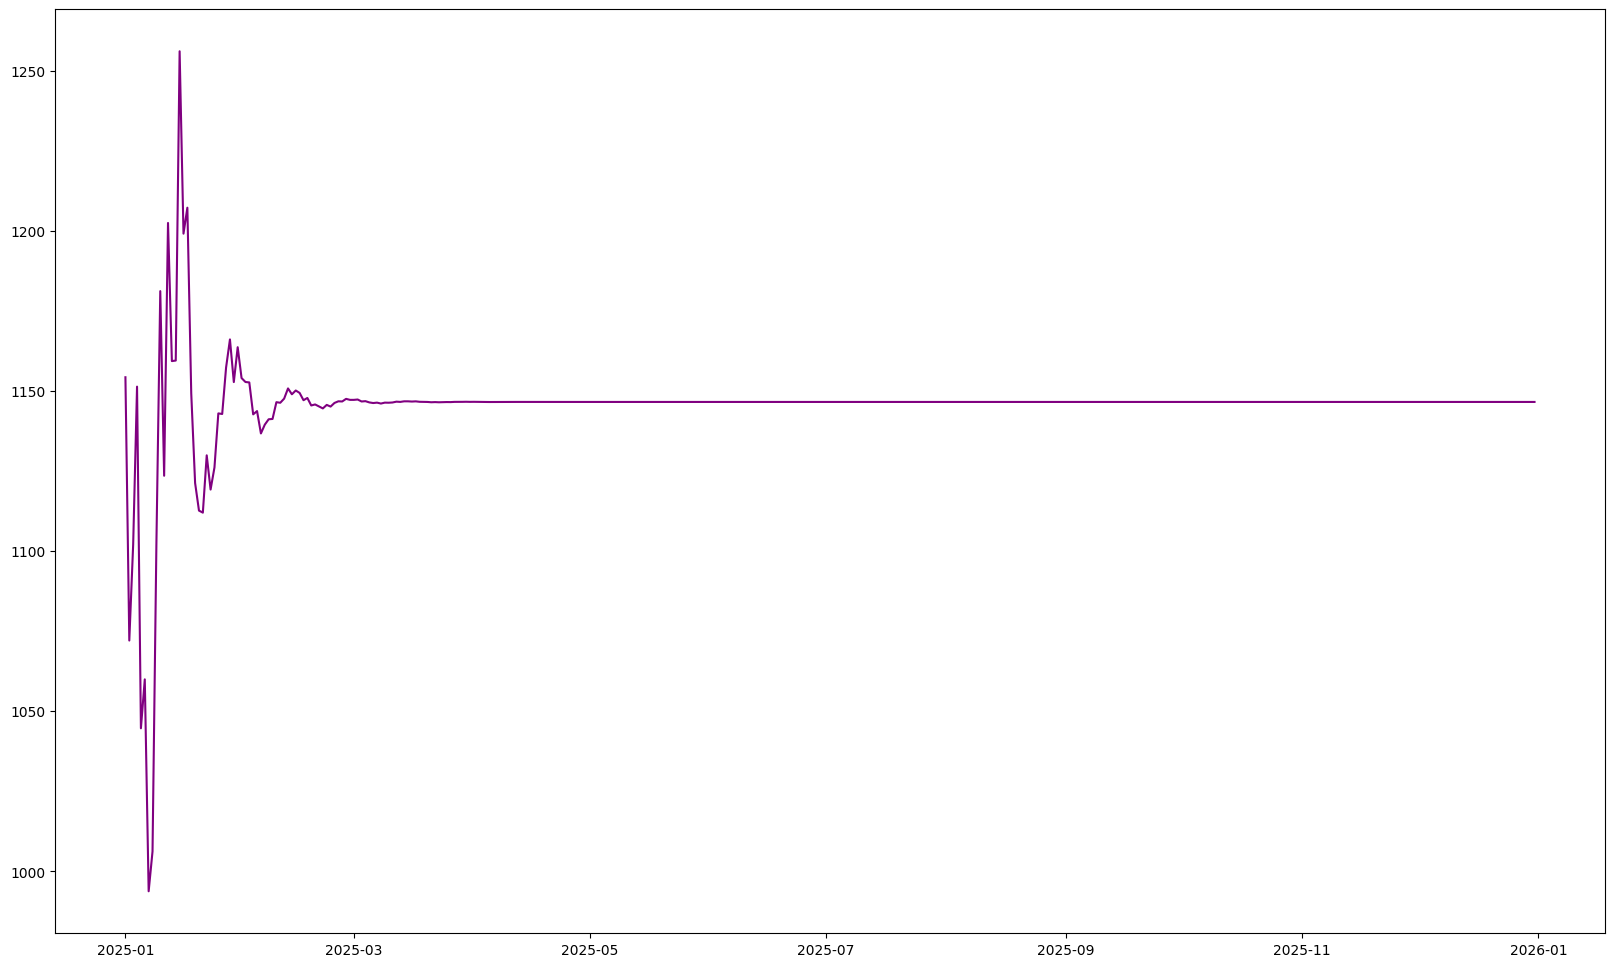

In [131]:
pred_rt_2025_l=pred_rt_2025.reset_index()

plt.figure(figsize=(20,12))
plt.plot(pred_rt_2025_l['index'],pred_rt_2025_l['Revenue'],color='purple' )
plt.show()

In [132]:
pred_rt_2025.to_csv('Revenue_Loss_2025.csv')